In [209]:
import pandas as pd
import numpy as np
import sqlite3
import dowhy
import causallearn
import matplotlib.pyplot as plt
import networkx as nx

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

In [29]:
pd.set_option("display.max_columns", 0)

In [47]:
CHEMBLDB_PATH = "/Users/patrickrowe/Documents/Code/data/chembl/chembl_35/chembl_35_sqlite/chembl_35.db"

SQL_QUERY = """SELECT * FROM ASSAYS WHERE ASSAY_TYPE IS 'P'"""
SQL_QUERY_WITH_IDS = """SELECT 
                        molregno, assays.assay_id, description, confidence_score, chembl_id, data_validity_comment, value, units, type
                        FROM assays
                        INNER JOIN activities AS act
                        ON assays.assay_id = act.assay_id 
                        WHERE ASSAY_TYPE is 'P'
                    """

In [48]:
con = sqlite3.connect(CHEMBLDB_PATH)
cur = con.cursor()

In [49]:
cur.execute(SQL_QUERY_WITH_IDS)

In [50]:
column_headers = [d[0] for d in cur.description]
print("molregno" in column_headers)
print(column_headers)
print(cur.fetchone())

True
['molregno', 'assay_id', 'description', 'confidence_score', 'chembl_id', 'data_validity_comment', 'value', 'units', 'type']
(146533, 4508, 'Partition coefficient was measured in octanol/pH7.4 phosphate buffer as -log (counts per min )', 0, 'CHEMBL618175', None, 0.5, 'c.p.m.', 'logP')


In [51]:
chembl_a_p_raw = pd.read_sql_query(SQL_QUERY_WITH_IDS, con=con)

In [52]:
chembl_a_p_raw

,molregno,assay_id,description,confidence_score,chembl_id,data_validity_comment,value,units,type
0,146533,4508,Partition coefficient was measured in octanol/...,0,CHEMBL618175,None,0.50,c.p.m.,logP
1,195927,4894,Partition coefficient (logP),0,CHEMBL858280,None,2.85,None,logP
2,195926,4894,Partition coefficient (logP),0,CHEMBL858280,None,3.73,None,logP
3,195915,4894,Partition coefficient (logP),0,CHEMBL858280,None,4.37,None,logP
4,195677,4894,Partition coefficient (logP),0,CHEMBL858280,None,3.97,None,logP
...,...,...,...,...,...,...,...,...,...
181530,2881545,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,3.60,None,LogD
181531,2881907,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,2.90,None,LogD
181532,2881578,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,3.00,None,LogD
181533,2881544,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,-0.50,None,LogD


In [53]:
chembl_a_p = chembl_a_p_raw[chembl_a_p_raw.groupby("description").transform("size") > 500]


In [54]:
print(f"Began with {len(chembl_a_p_raw)} rows, for {len(set(chembl_a_p_raw.description.to_list()))} assays and {len(set(chembl_a_p_raw.chembl_id.to_list()))} molecules.\n")
print(f"Filtered to {len(chembl_a_p)} rows, for {len(set(chembl_a_p.description.to_list()))} assays and {len(set(chembl_a_p.chembl_id.to_list()))} moleucles.\n")
print(f"{chembl_a_p["description"].value_counts()}")


Began with 181535 rows, for 17943 assays and 25734 molecules.

Filtered to 38808 rows, for 22 assays and 3709 moleucles.

description
Partition coefficient (logP)                                                                                                                                                         5843
ASTRAZENECA: Octan-1-ol/water (pH7.4) distribution coefficent measured  by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355. Experimental range -1.5 to 4.5    4200
Dissociation constant, pKa of the compound                                                                                                                                           3396
Lipophilicity, log P of the compound                                                                                                                                                 2850
Lipophilicity, log D of the compound at pH 7.4                                                                            

In [152]:
chembl_a_p.columns

Index(['molregno', 'assay_id', 'description', 'confidence_score', 'chembl_id',
       'data_validity_comment', 'value', 'units', 'type'],
      dtype='object')

In [184]:
pivoted = pd.pivot_table(chembl_a_p, values=['value'], index='molregno', columns=['description']).sort_index().pipe(
    lambda s: s.set_axis(s.columns.map("_".join), axis=1)
)

In [189]:
# Preprocessing: Data cleaning

# Only select molecules with >3 measurements each
pivoted = pivoted[pivoted.notna().sum(axis=1).gt(3)]
# Fill nans with mean
pivoted = pivoted.fillna(value=pivoted.mean(axis=0))

# Normalise based on mean, set "nearly 0" to zero for convenience
pivoted = pivoted - pivoted.mean(axis=0)
pivoted[np.abs(pivoted) < 1e-9] = 0

# Some sets of assays (e.g. HPLC) are orthogonal to others, so drop these columns
pivoted = pivoted.dropna(axis=1)

In [190]:
pivoted

,"value_ASTRAZENECA: Octan-1-ol/water (pH7.4) distribution coefficent measured by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355. Experimental range -1.5 to 4.5","value_ASTRAZENECA: Solubility in pH7.4 buffer using solid starting material using the method described in J. Assoc. Lab. Autom. 2011, 16, 276-284. Experimental range 0.10 to 1500 uM",value_Aqueous solubility of compound,value_Aqueous solubility of the compound,value_Aqueous solubility of the compound at pH 7.4,value_Calculated partition coefficient (clogP),value_Dissociation constant (pKa),"value_Dissociation constant, pKa of the compound",value_Ionization constant (pKa),value_Kinetic solubility of the compound,"value_Lipophilicity, log D at pH 7.4","value_Lipophilicity, log D of the compound","value_Lipophilicity, log D of the compound at pH 7.4","value_Lipophilicity, log P of the compound","value_Octanol-water partition coefficient, log P of the compound",value_Partition coefficient (logD7.4),value_Partition coefficient (logP),"value_Partition coefficient, log P of the compound",value_Solubility in water,value_Solubility of the compound,value_Solubility of the compound in water
molregno,,,,,,,,,,,,,,,,,,,,,
97,0.122853,-272.913636,0.000000,0.000000,0.0,0.00000,0.000000,-0.768961,-1.177531,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000,0.0
115,-1.277147,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,-1.778961,0.372469,0.0,0.0,0.000000,0.000000,-1.319023,0.000000,-1.1365,0.000000,-1.582296,0.0000,0.000,0.0
173,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,-3.848077,-3.047295,-3.177531,0.0,0.0,-0.751552,0.000000,1.290977,0.000000,-0.5365,-0.371548,1.517704,0.0000,0.000,0.0
241,-2.737147,0.000000,0.000000,0.000000,0.0,-0.70445,0.000000,-0.108961,0.000000,0.0,0.0,0.000000,0.000000,-1.389023,0.000000,-2.4965,-3.531548,-1.822796,0.0000,35.255,0.0
246,-2.647147,0.000000,0.000000,0.000000,0.0,-0.45320,0.000000,-1.218961,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-2.5365,0.000000,-3.782296,0.0000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450253,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,-3.208961,-3.177531,0.0,0.0,0.000000,0.000000,1.460977,2.683411,0.0000,0.000000,0.000000,0.0000,0.000,0.0
1528036,0.802853,179.986364,0.000000,0.000000,0.0,0.00000,0.000000,3.901039,0.000000,0.0,0.0,0.000000,0.125122,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000,0.0
1529232,1.422853,0.000000,-51.201875,-834.881788,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,1.638448,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000,0.0


In [ ]:
# TODO: Set node names!

cg = pc(pivoted.to_numpy())

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/21 [00:00<?, ?it/s]

In [230]:
cg

In [ ]:
cg.to_nx_graph()


In [238]:
chembl_causal_graph = cg.nx_graph

In [258]:
chembl_causal_graph = nx.relabel_nodes(chembl_causal_graph, {x: name for x, name in enumerate(pivoted.columns.to_list())})

Green: undirected; Blue: directed; Red: bi-directed



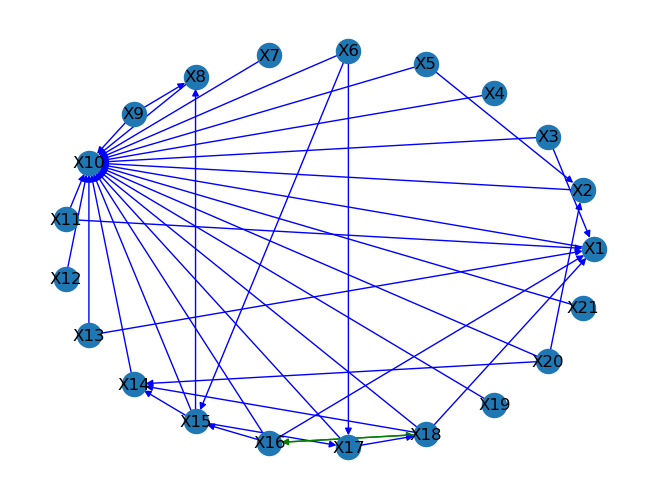

In [259]:
cg.draw_nx_graph()

In [262]:
def plot_causal_graph(G):
    pos = nx.spring_layout(G, seed=42, k=1)
    
    # Plot
    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=1500,
        node_color="#cce5ff",
        edgecolors="black",
        font_size=9,
        font_weight="bold",
        arrows=True,
        arrowstyle="-|>",
        arrowsize=20,
        connectionstyle="arc3,rad=0.2"
    )
    plt.title("Causal Graph of Physical Assays From ChEMBl", fontsize=14, fontweight="bold")
    plt.axis("off")
    plt.show()

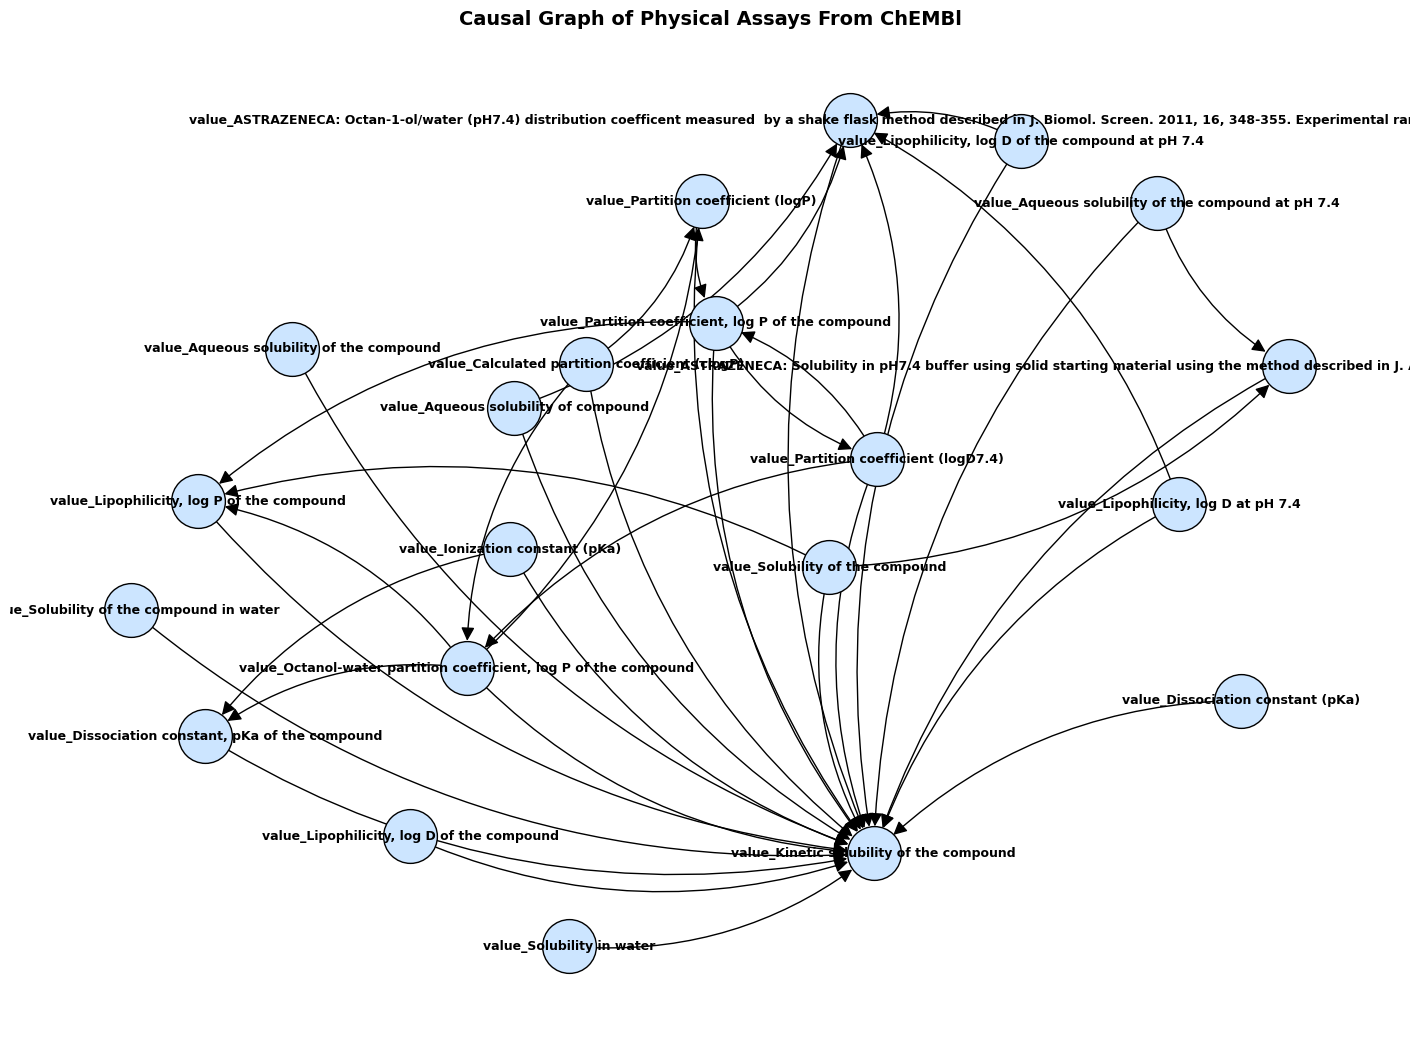

In [263]:
plot_causal_graph(chembl_causal_graph)